In [293]:
# ALL IMPORTS

import psycopg2 as pg
import datetime
import pandas.io.sql as psql
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import string
import random
import sklearn
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm

# Question Type counts in CS50 at Stack Exchange

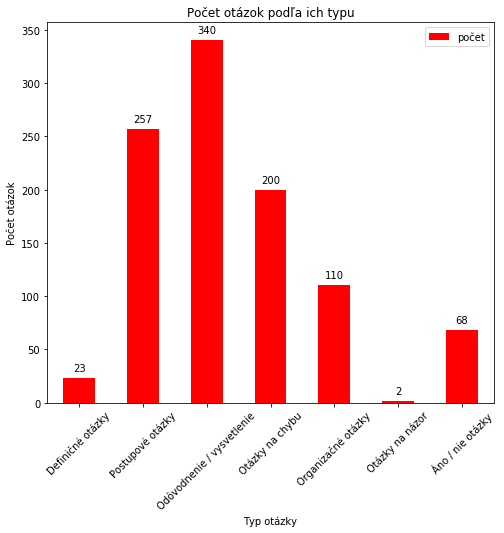

In [294]:
#CONNECTION TO DATABASE
try:
    conn = pg.connect("dbname='CS50' user='postgres' host='localhost' password='root'")
except:
    print ("I am unable to connect to the database")

df = psql.read_sql("SELECT * FROM questions WHERE question_type IS NOT NULL", conn)
dfCounts = psql.read_sql("SELECT count(questions.id) FROM questions WHERE question_type IS NOT NULL GROUP BY question_type ORDER BY question_type", conn);

ax = dfCounts.plot(kind='bar', color='red', title="Počet otázok podľa ich typu", figsize=(8,7))
ax.set_xlabel('Typ otázky')
ax.legend(['počet'])
ax.set_ylabel('Počet otázok')
ax.set_xticklabels(['Definičné otázky', 'Postupové otázky', 'Odôvodnenie / vysvetlenie', 'Otázky na chybu', 'Organizačné otázky', 'Otázky na názor', 'Áno / nie otázky'], rotation = 45)
for p in ax.patches:
   ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# Question type counts in Askalot at edX

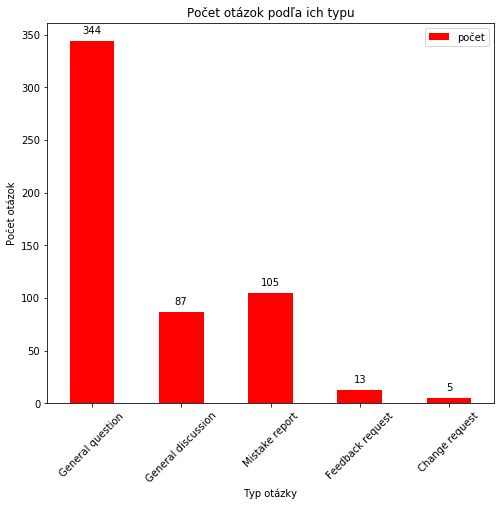

In [295]:
#CONNECTION TO DATABASE
try:
    conn2 = pg.connect("dbname='BP' user='postgres' host='localhost' password='root'")
except:
    print ("I am unable to connect to the database")
    
dfCounts = psql.read_sql("SELECT qt.name, count(questions.id) FROM questions  JOIN question_types as qt ON qt.id = questions.question_type_id GROUP BY question_type_id, qt.name ORDER BY question_type_id", conn2);


ax = dfCounts.plot(kind='bar', color='red', title="Počet otázok podľa ich typu", figsize=(8,7))
ax.set_xlabel('Typ otázky')
ax.legend(['počet'])
ax.set_ylabel('Počet otázok')
ax.set_xticklabels(['General question', 'General discussion', 'Mistake report', 'Feedback request', 'Change request'], rotation = 45)
for p in ax.patches:
   ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# Example how TF-IDF calculation works

In [296]:

#CountVectorizer implements both tokenization and occurrence counting in a single class:
vectorizer = CountVectorizer(min_df=1)
tfidf_tranformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(Xtrain)
X_train_counts.shape

X_train_tfidf = tfidf_tranformer.fit_transform(X_train_counts)
X_train_tfidf.shape

###### TEST CORPUS #####
X_test_counts = vectorizer.transform(Xtest)
X_test_counts.shape

X_test_tfidf = tfidf_tranformer.transform(X_test_counts)
X_test_tfidf.shape



NameError: name 'Xtrain' is not defined

# Methods for preprocessing, oversampling, classification and verification

In [297]:
def editPos(tag): 
#edits POS tagging returned by nltk POS tagger to format accepted by nltk lemmatizer    
    if (tag.startswith('V')):
        return 'v'
    elif (tag.startswith('N')):
        return 'n'
    elif (tag.startswith('R')):
        return 'r'
    elif (tag.startswith('J')):
        return 'a'
    else:
        return 'n' #lemmatizer default is noun

In [298]:
def lemmatizeSentence(sentence):
#lemmatize sentence with correct (and edited) POS tags returned by nltk POS tagger     
    tempList = []
    lmtzr = WordNetLemmatizer()
    tokenizedSentence = word_tokenize(sentence)
    posSentence = nltk.pos_tag(tokenizedSentence)
    for pair in posSentence:
        tempList.append(lmtzr.lemmatize(pair[0], editPos(pair[1])))
    return ' '.join(word for word in tempList)


In [299]:
def cleanCorpus(rawText, textPrep='stemming'):
#text preprocessing including lemmatization/stemming, punctation removal and stop word removal
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    stemmer = PorterStemmer()
    lmtzr = WordNetLemmatizer()
    cleanedCorpus = []

    for question in rawText:
        question = re.sub('<code>.*?</code>','',question, flags=re.DOTALL) #removal of all code
        question = re.sub('<.*?>', '', question)  #removal of all <> html tags

        question = question.lower() #change all characters to lower, for instance lemmatizer wont lemmatize carS, but lemmatize cars correctly
        
        if (textPrep == 'lemmatization'):
            temp = []
            for sentence in tokenizer.tokenize(question): #for every sentence in question  
                temp.append(lemmatizeSentence(sentence)) #lemmatize words
            question = ' '.join(word for word in temp)
        
        question = ' '.join(RegexpTokenizer(r'\w+').tokenize(question)) #tokenization withut interpuntions

        querywords = question.split() #breaks whole question into words for stopword removal

        if (textPrep == 'stemming'):
            for i in range(0, len(querywords) - 1):
                querywords[i] = stemmer.stem(querywords[i])

        resultwords  = [word for word in querywords if word not in stopwords.words('english')] 

        question = ' '.join(resultwords)
        cleanedCorpus.append(question)
    return cleanedCorpus

In [300]:
def sample(size, Xtrain, Ytrain):
   
    trainSet = list(zip(Xtrain, Ytrain)) #merge both lists as pairs
    
    sets = []
    
    npUniqe = np.unique(Ytrain) #finds uniqe elements in Ytrain (labels)
    for i in range(0, npUniqe.size): #split trainSet into sets by Y-label
        sets.append([question for question in trainSet if question[1] == npUniqe[i]])
    
        #first find sets that are lower than specified value and remove random elemets to match specified size
        
        if (len(sets[i]) > size):      #shuffles are for random forests for instance
            random.shuffle(sets[i])    #shuffle set
            sets[i] = sets[i][:size]   #remove last (sets[i].size - size) elemets so the final size will match size in argument
        elif (len(sets[i]) < size):    #duplicate elements so the final size match size in argument         
            temp = []
            for j in range(0, size):   #iterate every element in set in circle until size is reached
                k = j % len(sets[i])
                temp.append(sets[i][k])
            random.shuffle(temp)       #shuffle set
            sets[i] = temp             #save temp as set
   

    
    #append all subSets created in sets[] and shuffle them
    result = []    
    for subSet in sets:
        result += subSet
    random.shuffle(result)
    
    return result #unzip necessary

In [301]:
#prevzate z 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html (23.4.2017)
#sluzi len na vykreslenie confusion matice
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [302]:
def classifyX(Xtrain, Ytrain, Xtest, Ytest,
             classif=SGDClassifier(loss='hinge', 
                                   penalty='l2', class_weight=None, alpha=1e-3, 
                                   n_iter=5, random_state=42),
             parameters={'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]},
             useGridSearch=True, ngram=(1, 1),
             printResults=True):
    
#will classify and train sets obtained as arguments    
    classificator = Pipeline([('vect', CountVectorizer(ngram_range=ngram)), 
                      ('tfidf', TfidfTransformer()),
                      ('clf', classif)])
    
    
    if (useGridSearch):
        GSClassificator = GridSearchCV(classificator, parameters, n_jobs=-1) #gridSearch init with specified params
        GSClassificator = GSClassificator.fit(Xtrain, Ytrain)                #actual grid search on Xtrain and Ytrain
        print("Best score: ", GSClassificator.best_score_)
        print("Best params: ", GSClassificator.best_params_)
        predicted = GSClassificator.predict(Xtest)    
    else:
        classificator.fit(Xtrain, Ytrain)
        predicted = classificator.predict(Xtest)
        
    
    #all necessities for plotting confusion matrix   
    cnf_matrix = sklearn.metrics.confusion_matrix(Ytest, predicted)
    np.set_printoptions(precision=2) 

    if (printResults):
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=[2,3,4,5],
                          title='Confusion matrix, without normalization')
    
    
    if (printResults):
        temp = [0, 0, 0, 0, 0, 0, 0, 0]
        temp2 = [0, 0, 0, 0, 0, 0, 0, 0]

        for i in range(0, predicted.size - 1):
            if (predicted[i] == Ytest[i]):
                temp[predicted[i]] = temp[predicted[i]] + 1

        for i in range(0, len(Ytest) - 1):
            temp2[Ytest[i]] += 1

        i = 0;
        for a in temp:
            if (temp2[i] != 0):
                print(i, ": ",  temp2[i], "-->", a, " = ", a / temp2[i])
            i += 1

    
        print(classification_report(Ytest, predicted, digits=4)) 
        
    return predicted

# ------------------------------------------------------------------------------

# Connection to database

In [303]:
#CONNECTION TO DATABASE
try:
    conn = pg.connect("dbname='CS50' user='postgres' host='localhost' password='root'")
except:
    print ("I am unable to connect to the database")

# SQL read 

categories 1 and 6 are removed becasue of poor representation in dataset

In [304]:
dfcs = psql.read_sql("SELECT * FROM questions WHERE question_type IS NOT NULL AND question_type != 1 AND question_type != 6 AND question_type != 7", conn)

# Obtaining data
Creating two variables containing **preprocessed** questions first one using *stemming* and second one using *lemmatization*

Labels for each questions are in *label* variable with proper indexes

In [305]:
#obtaining data as well as labels
data_stemmed = cleanCorpus(rawText = dfcs["raw_text"], textPrep = 'stemming')
data_lemmatized = cleanCorpus(rawText = dfcs["raw_text"], textPrep = 'lemmatization')
labels = dfcs["question_type"].tolist()

# Splitting corpus into train and test sets

In [306]:
#train and test sets for stemmed questions
Xtrain_stm, Xtest_stm, Ytrain_stm, Ytest_stm = train_test_split(data_stemmed, labels, test_size=0.33, random_state=42)

#train and test sets for lemmatized questions
Xtrain_lmt, Xtest_lmt, Ytrain_lmt, Ytest_lmt = train_test_split(data_lemmatized, labels, test_size=0.33, random_state=42)

# Create oversampled train set for stemmed and lemmatized data

In [307]:
unzip_stm = list(zip(*sample(300, Xtrain_stm, Ytrain_stm)))
Xtrain_stm_oversampled = unzip_stm[0]
Ytrain_stm_oversampled = unzip_stm[1]

unzip_lmt = list(zip(*sample(300, Xtrain_lmt, Ytrain_lmt)))
Xtrain_lmt_oversampled = unzip_lmt[0]
Ytrain_lmt_oversampled = unzip_lmt[1]


# SVM classification - stemmed questions
classification using **SVM**

oversampling - **NO**

undersampling - **NO**




Best score:  0.576606260297
Best params:  {'clf__C': 10, 'clf__class_weight': None, 'clf__decision_function_shape': 'ovo', 'vect__ngram_range': (1, 2)}
Confusion matrix, without normalization
[[45 26 14  7]
 [13 89 11  1]
 [ 9 32 25  1]
 [ 1  6  0 20]]
2 :  92 --> 45  =  0.4891304347826087
3 :  114 --> 89  =  0.7807017543859649
4 :  67 --> 25  =  0.373134328358209
5 :  26 --> 20  =  0.7692307692307693
             precision    recall  f1-score   support

          2     0.6618    0.4891    0.5625        92
          3     0.5817    0.7807    0.6667       114
          4     0.5000    0.3731    0.4274        67
          5     0.6897    0.7407    0.7143        27

avg / total     0.5977    0.5967    0.5856       300



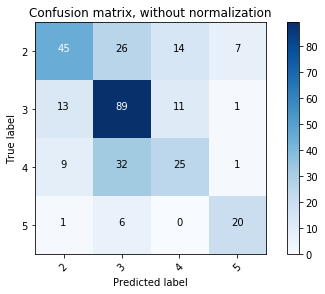

In [323]:
_ = classifyX(Xtrain_stm, Ytrain_stm, Xtest_stm, Ytest_stm, classif=svm.SVC(kernel='linear'), useGridSearch=True,
         parameters={'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 
                     'clf__C':[(1000), (100), (10), (1.0), (0.01), (0.001), (0.0001)],
                     'clf__decision_function_shape':[('ovo'), ('ovr')],
                     'clf__class_weight':[(None), ('balanced')]})

## STEMMING
classification using **SVM**

oversampling - **YES** 3 categories

undersampling - **YES** 1 category

Confusion matrix, without normalization
[[47 24 14  7]
 [14 88 11  1]
 [ 9 32 25  1]
 [ 2  6  0 19]]
2 :  92 --> 47  =  0.5108695652173914
3 :  114 --> 88  =  0.7719298245614035
4 :  67 --> 25  =  0.373134328358209
5 :  26 --> 19  =  0.7307692307692307
             precision    recall  f1-score   support

          2     0.6528    0.5109    0.5732        92
          3     0.5867    0.7719    0.6667       114
          4     0.5000    0.3731    0.4274        67
          5     0.6786    0.7037    0.6909        27

avg / total     0.5959    0.5967    0.5867       300



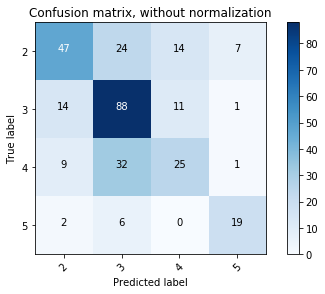

In [324]:
_ = classifyX(Xtrain_stm_oversampled, Ytrain_stm_oversampled, Xtest_stm, Ytest_stm, classif=svm.SVC(kernel='linear', C=6.5, decision_function_shape='ovo'), useGridSearch=False, ngram=(1, 2))

# SVM classification - lemmatized questions
classification using **SVM**

oversampling - **NO**

undersampling - **NO**




Best score:  0.566721581549
Best params:  {'clf__C': 1.0, 'clf__class_weight': 'balanced', 'clf__decision_function_shape': 'ovo', 'vect__ngram_range': (1, 2)}
Confusion matrix, without normalization
[[35 34 16  7]
 [14 78 21  1]
 [ 6 31 29  1]
 [ 3  6  1 17]]
2 :  92 --> 35  =  0.3804347826086957
3 :  114 --> 78  =  0.6842105263157895
4 :  67 --> 29  =  0.43283582089552236
5 :  26 --> 17  =  0.6538461538461539
             precision    recall  f1-score   support

          2     0.6034    0.3804    0.4667        92
          3     0.5235    0.6842    0.5932       114
          4     0.4328    0.4328    0.4328        67
          5     0.6538    0.6296    0.6415        27

avg / total     0.5395    0.5300    0.5229       300



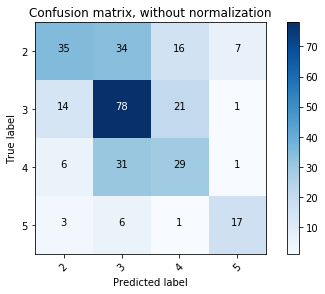

In [325]:
_ = classifyX(Xtrain_lmt, Ytrain_lmt, Xtest_lmt, Ytest_lmt, classif=svm.SVC(kernel='linear'), useGridSearch=True,
         parameters={'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 
                     'clf__C':[(1000), (100), (10), (1.0), (0.01), (0.001), (0.0001)],
                     'clf__decision_function_shape':[('ovo'), ('ovr')],
                     'clf__class_weight':[(None), ('balanced')]})

classification using **SVM**

oversampling - **YES** 3 categories

undersampling - **YES** 1 category

Confusion matrix, without normalization
[[37 32 17  6]
 [15 80 18  1]
 [ 8 29 29  1]
 [ 2  7  1 17]]
2 :  92 --> 37  =  0.40217391304347827
3 :  114 --> 80  =  0.7017543859649122
4 :  67 --> 29  =  0.43283582089552236
5 :  26 --> 17  =  0.6538461538461539
             precision    recall  f1-score   support

          2     0.5968    0.4022    0.4805        92
          3     0.5405    0.7018    0.6107       114
          4     0.4462    0.4328    0.4394        67
          5     0.6800    0.6296    0.6538        27

avg / total     0.5493    0.5433    0.5364       300



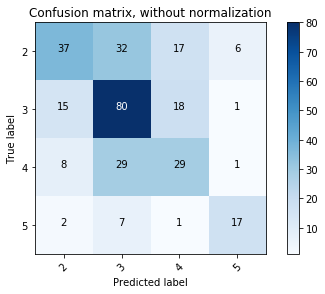

In [334]:
_ = classifyX(Xtrain_lmt_oversampled, Ytrain_lmt_oversampled, Xtest_lmt, Ytest_lmt, classif=svm.SVC(kernel='linear', C=0.9, decision_function_shape='ovo'), useGridSearch=False, ngram=(1, 2))

# -----RANDOM FOREST CLASSIFICATION-----

# STEMMED QUESTIONS
classification using **RANDOM FOREST**

oversampling - **NO**

undersampling - **NO**

Best score:  0.594728171334
Best params:  {'clf__min_samples_split': 5, 'clf__n_estimators': 500, 'vect__ngram_range': (1, 1)}
Confusion matrix, without normalization
[[39 36 14  3]
 [10 92 12  0]
 [ 7 25 33  2]
 [ 3  9  0 15]]
2 :  92 --> 39  =  0.42391304347826086
3 :  114 --> 92  =  0.8070175438596491
4 :  67 --> 33  =  0.4925373134328358
5 :  26 --> 15  =  0.5769230769230769
             precision    recall  f1-score   support

          2     0.6610    0.4239    0.5166        92
          3     0.5679    0.8070    0.6667       114
          4     0.5593    0.4925    0.5238        67
          5     0.7500    0.5556    0.6383        27

avg / total     0.6109    0.5967    0.5862       300



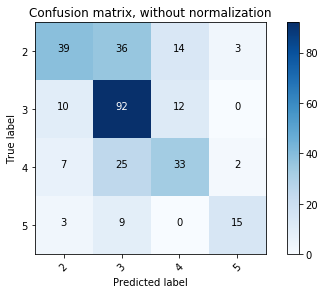

In [335]:

_ = classifyX(Xtrain_stm, Ytrain_stm, Xtest_stm, Ytest_stm, classif=RandomForestClassifier(n_jobs=-1, random_state=42),  
          parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                        'clf__n_estimators': (10,100,200,300,500,1000,2000),
                        'clf__min_samples_split': [(2), (5), (10)]})


## STEMMING
classification using **RANDOM FOREST**

oversampling - **YES** 3 categories

undersampling - **YES** 1 categories

Confusion matrix, without normalization
[[40 26 16 10]
 [11 78 24  1]
 [10 16 38  3]
 [ 0  5  0 22]]
2 :  92 --> 40  =  0.43478260869565216
3 :  114 --> 78  =  0.6842105263157895
4 :  67 --> 38  =  0.5671641791044776
5 :  26 --> 21  =  0.8076923076923077
             precision    recall  f1-score   support

          2     0.6557    0.4348    0.5229        92
          3     0.6240    0.6842    0.6527       114
          4     0.4872    0.5672    0.5241        67
          5     0.6111    0.8148    0.6984        27

avg / total     0.6020    0.5933    0.5883       300



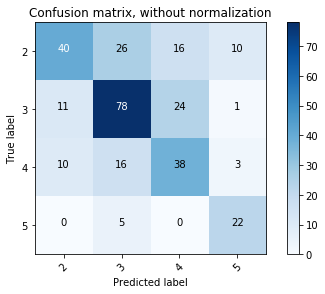

In [336]:
_ = classifyX(Xtrain_stm_oversampled, Ytrain_stm_oversampled, Xtest_stm, Ytest_stm, classif=RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42, min_samples_split=5), useGridSearch=False, ngram=(1, 2))

# LEMMATIZED QUESTIONS
classification using **RANDOM FOREST**

oversampling - **NO**

undersampling - **NO**

Best score:  0.570016474465
Best params:  {'clf__min_samples_split': 2, 'clf__n_estimators': 500, 'vect__ngram_range': (1, 1)}
Confusion matrix, without normalization
[[33 40 15  4]
 [14 80 18  2]
 [ 7 29 30  1]
 [ 1  7  1 18]]
2 :  92 --> 33  =  0.358695652173913
3 :  114 --> 80  =  0.7017543859649122
4 :  67 --> 30  =  0.44776119402985076
5 :  26 --> 18  =  0.6923076923076923
             precision    recall  f1-score   support

          2     0.6000    0.3587    0.4490        92
          3     0.5128    0.7018    0.5926       114
          4     0.4688    0.4478    0.4580        67
          5     0.7200    0.6667    0.6923        27

avg / total     0.5484    0.5367    0.5275       300



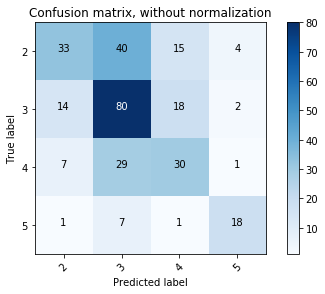

In [337]:
_ = classifyX(Xtrain_lmt, Ytrain_lmt, Xtest_lmt, Ytest_lmt, classif=RandomForestClassifier(n_jobs=-1, random_state=42),  
          parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                        'clf__n_estimators': (10,100,200,300,500,1000,2000),
                        'clf__min_samples_split': [(2), (5), (10)]})


# LEMMATIZED QUESTIONS
classification using **RANDOM FOREST**

oversampling - **YES** 3 categories

undersampling - **YES** 1 category

Confusion matrix, without normalization
[[39 31 14  8]
 [12 68 31  3]
 [ 8 17 40  2]
 [ 0  4  0 23]]
2 :  92 --> 39  =  0.42391304347826086
3 :  114 --> 68  =  0.5964912280701754
4 :  67 --> 40  =  0.5970149253731343
5 :  26 --> 22  =  0.8461538461538461
             precision    recall  f1-score   support

          2     0.6610    0.4239    0.5166        92
          3     0.5667    0.5965    0.5812       114
          4     0.4706    0.5970    0.5263        67
          5     0.6389    0.8519    0.7302        27

avg / total     0.5806    0.5667    0.5625       300



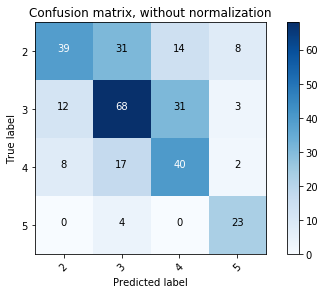

In [338]:
_ = classifyX(Xtrain_lmt_oversampled, Ytrain_lmt_oversampled, Xtest_lmt, Ytest_lmt, classif=RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, min_samples_split=2), useGridSearch=False, ngram=(1, 1))

# ------END------

# Question Text before and after preprocessing (with use of stemming)

In [339]:
print(dfcs['raw_text'][134])

<p>In pset2  when I write this code:</p>

<pre><code>string in = GetString();
char a = in[0];
if(isupper(in[0])) printf("Gotcha\n");
</code></pre>

<p>I input string "Be sure" and I expected "Gotcha" to be printed out but it was not. When I write this code instead:</p>

<pre><code>if(isupper(a)) printf("Gotcha\n");
</code></pre>

<p>Surprisingly, "Gotcha" was printed out! Why didn't it print out before?</p>



In [340]:
print(data_stemmed[134])

pset2 write thi code input string sure expect gotcha print wa write thi code instead surprisingli gotcha wa print whi print


# Example of how to test data on custom question with use of lemmatization:

2 - Postupové otázky

3 - Otázky ktoré očakávajú odôvodnenie alebo vysvetlenie 

4 - Otázky na chybu

5 - Organizačné otázky


In [342]:
#These questions were custom made they are not part of dataset

sentences = [lemmatizeSentence("How can I install this software?"),
             lemmatizeSentence("Can someone explain me how to create array in C?"),
             lemmatizeSentence("When will be grades available for pset1?")]

print(classifyX(Xtrain_lmt, Ytrain_lmt, 
                sentences, [0] * len(sentences), 
                classif=svm.SVC(kernel='linear', C=0.9, decision_function_shape='ovo'), 
                useGridSearch=False, 
                ngram=(1, 2),
                printResults=False))

[2 3 5]
